In [53]:
import pandas as pd
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
# import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
# from tqdm import tqdm
# import meteva as mem
# from meteva.method import pc
from sklearn.feature_selection import mutual_info_classif
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
from scipy.stats import pointbiserialr
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler

In [54]:
def scheduler(epoch, lr):
    if epoch == 100:
        return lr * 0.1
    else:
        return lr

In [55]:
def mix_feature(data):
    # Selecting numerical features for interaction term creation
    numerical_features = data.select_dtypes(include=['float64', 'int64']).drop(columns=['date', 'year', 'month', 'day', 'fire', 'lon', 'lat'])

    # Creating interaction terms using PolynomialFeatures
    polynomial_features = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    interaction_features = polynomial_features.fit_transform(numerical_features)

    # Creating a DataFrame to hold the new interaction features
    interaction_features_df = pd.DataFrame(interaction_features)

    # Rename interaction features to ensure uniqueness
    new_feature_names = [f'feature_{i}' for i in range(interaction_features_df.shape[1])]
    interaction_features_df.columns = new_feature_names

    # Merging the interaction features with the original dataset
    data_with_interactions = pd.concat([data, interaction_features_df], axis=1)
    return data_with_interactions


In [56]:
def select_features(df,thus):
    selected_features = []
    
    # Loop through each feature column to calculate the Point-Biserial Correlation Coefficient
    for column in df.columns:
        if column not in ['fire', 'date', 'year', 'month', 'day', 'lon', 'lat']:
            coeff, _ = pointbiserialr(df[column], df['fire'])
            if abs(coeff) >= thus:
                selected_features.append(column)
    
    print(f'Features with Point-Biserial Correlation Coefficient > {thus}: {selected_features}')
    
    # Combine selected features with other necessary columns
    final_features = ['fire', 'date', 'year', 'month', 'day', 'lon', 'lat'] + selected_features
    
    return final_features
# def select_features(df, threshold):
#     """
#     Select features based on Mutual Information.
    
#     Parameters:
#         df (DataFrame): The input data frame containing both features and target variable.
#         threshold (float): The mutual information threshold for feature selection.
    
#     Returns:
#         list: The names of selected features.
#     """
#     # Filter out columns that should not be used for mutual information calculation
#     feature_columns = [col for col in df.columns if col not in ['fire', 'date', 'year', 'month', 'day', 'lon', 'lat']]
    
#     # Calculate Mutual Information scores
#     mutual_info_scores = mutual_info_classif(df[feature_columns], df['fire'])
    
#     # Select features based on the threshold
#     selected_features = [feature_columns[i] for i in range(len(feature_columns)) if mutual_info_scores[i] >= threshold]
    
#     print(f'Features with Mutual Information >= {threshold}: {selected_features}')
    
#     # Combine selected features with other necessary columns
#     final_features = ['fire', 'date', 'year', 'month', 'day', 'lon', 'lat'] + selected_features
    
#     return final_features

In [57]:
def process_outlier(df,feats):
    _ = df[feats[0:]]
    # 1. 计算每个气象要素的平均值和标准差
    mean_values = _.mean()
    std_values = _.std()
    # 2. 根据三倍标准差法，设定异常值的阈值
    threshold = 3 * std_values
    # 3. 遍历每个气象要素的数值，将超过设定阈值的值标记为异常值
    is_outlier = (_ > mean_values + threshold) | (_ < mean_values - threshold)
    # 4. 对于标记为异常值的数据，可以根据需要选择删除、替换或进行插补处理
    # 假设你选择删除异常值
    df = df[~is_outlier.any(axis=1)]
#     df = df.query('sw_max1<20 and sw_max2<20')
     
    return df

In [58]:
data = pd.read_csv('fire_point_data.csv')
fire_count = data['fire'].value_counts()
print(fire_count)
data = data.drop(columns=['Unnamed: 0'])
data['date'] = pd.to_datetime(data['date'])
scaler = StandardScaler()
data['date'] = scaler.fit_transform(data['date'].values.reshape(-1, 1))

#data = data.drop(columns=['Unnamed: 0'], inplace=True)
# 对分类特征进行独热编码
data = pd.get_dummies(data, columns=['area'])
data = mix_feature(data)
feats_name = select_features(data, 0.1)
data = process_outlier(data,feats_name)


fire
1    4531
0    3253
Name: count, dtype: int64
Features with Point-Biserial Correlation Coefficient > 0.1: ['Alti', 'TEM_Max', 'TEM_Min', 'RHU_Min', 'FFDI', 'area_黑龙江省', 'feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_23', 'feature_25', 'feature_26', 'feature_28', 'feature_30', 'feature_47', 'feature_49', 'feature_51', 'feature_53', 'feature_58', 'feature_70', 'feature_73', 'feature_75', 'feature_87', 'feature_92', 'feature_96', 'feature_133', 'feature_170']


In [59]:
train_data = data[data['year']!=2017]
pred_data = data[data['year']==2017]
fire_count = train_data['fire'].value_counts()
print(fire_count)

fire
1    3799
0    2576
Name: count, dtype: int64


In [60]:
# train_data = data.dropna()
fire_count = train_data['fire'].value_counts()
print(fire_count)
# 定义特征和目标变量
x = train_data.drop('fire', axis=1)
y = train_data['fire']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# 特征标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 构建神经网络模型
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


fire
1    3799
0    2576
Name: count, dtype: int64


In [65]:


# 创建EarlyStopping回调
early_stopping = EarlyStopping(monitor='accuracy', patience=100, restore_best_weights=True)


# 创建 LearningRateScheduler 回调
lr_scheduler = LearningRateScheduler(scheduler)

# 将 lr_scheduler 添加到回调列表中
callbacks = [early_stopping, lr_scheduler]

optimizer = Adam(lr=0.001)
# 编译模型
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


# 训练模型
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.2, callbacks=callbacks)

# 模型评估
loss, mae = model.evaluate(X_test, y_test)
print("Test Loss: {:.2f}".format(loss))
print(f"Mean Absolute Error: {mae}")

Epoch 1/1000
128/128 [==============================] - 1s 3ms/step - loss: 0.0389 - accuracy: 0.9897 - val_loss: 0.2745 - val_accuracy: 0.9373 - lr: 0.0010
Epoch 2/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0449 - accuracy: 0.9890 - val_loss: 0.2619 - val_accuracy: 0.9382 - lr: 0.0010
Epoch 3/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0422 - accuracy: 0.9895 - val_loss: 0.2837 - val_accuracy: 0.9363 - lr: 0.0010
Epoch 4/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0552 - accuracy: 0.9843 - val_loss: 0.2510 - val_accuracy: 0.9392 - lr: 0.0010
Epoch 5/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0369 - accuracy: 0.9924 - val_loss: 0.2481 - val_accuracy: 0.9451 - lr: 0.0010
Epoch 6/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0350 - accuracy: 0.9924 - val_loss: 0.2515 - val_accuracy: 0.9441 - lr: 0.0010
Epoch 7/1000
128/128 [==============================] - 0s

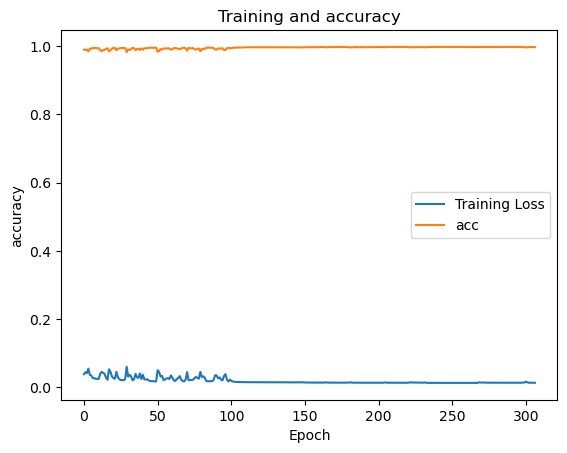

In [66]:
# 绘制训练损失和验证损失
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='acc')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Training and accuracy')
path = 'acc.png'
plt.savefig(path, dpi=300)
plt.show()